<a href="https://colab.research.google.com/github/Aidandos/cola/blob/main/cola.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COLA: Consistent Learning with Opponent-Learning Awareness

Welcome to the code accompanying our paper. This notebook contains an implementation of COLA and other general-sum learning algorithms. This notebook allows to run COLA on a set of zero-sum and general-sum games. Parts of this code were taken from https://github.com/aletcher/stable-opponent-shaping

## Which game do you want to run?
There is


*   Matching Pennies
*   IPD
*   Ultimatum
*   Tandem
*   Hamiltonian
*   Balduzzi
*   Chicken Game



In [ ]:
import os, sys
import logging
import argparse
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.fft as fft
import torch.nn as nn
from datetime import datetime
import seaborn as sns
from scipy import stats

from torch.nn import CosineSimilarity
cos = CosineSimilarity(dim=1, eps=1e-15)
!pip install ipython-autotime

markers = ['o', 'v', '^', '*',  's', 'D']
colors = ['blue', 'red', 'green', 'purple']
# sns.set_theme(style="darkgrid")
sns.set_theme(style="ticks")

fontsize=30
%load_ext autotime

game = 'Matching Pennies' #@param ["Matching Pennies", "IPD", "Ultimatum", "Chicken Game", "Tandem", "Balduzzi", "Hamiltonian"]

time: 1.87 ms (started: 2022-03-04 02:28:52 +00:00)


## Game Definitions

In [ ]:
def tandem():
    dims = [1, 1]

    def Ls(th):
        x, y = th
        # Tandem loss (quadratic loss for moving forward + linear penalty for pedalling backwards)
        L_1 = (x + y)**2 - 2.0 * x
        L_2 = (x + y)**2 - 2.0 * y
        return [L_1, L_2]
    return dims, Ls


def tandem_cubed():
    dims = [1, 1]

    def Ls(th):
        x, y = th
        # Tandem loss (quadratic loss for moving forward + linear penalty for pedalling backwards)
        L_1 = (x + y)**4 - 2.0 * x
        L_2 = (x + y)**4 - 2.0 * y
        return [L_1, L_2]
    return dims, Ls


def ultimatum():
  dims = [1, 1]
  def Ls(th):
    x, y = th
    p_fair = torch.sigmoid(x)
    p_accept = torch.sigmoid(y)
    L_1 = -(5*p_fair + 8*(1-p_fair)*p_accept)
    L_2 = -(5*p_fair + 2*(1-p_fair)*p_accept)
    return [L_1, L_2]
  return dims, Ls


def balduzzi():
  dims = [1, 1]
  def Ls(th):
    x, y = th
    L_1 = 0.5*(x**2) + 10*x*y
    L_2 = 0.5*(y**2) - 10*x*y
    return [L_1, L_2]
  return dims, Ls


def hamiltonian_game():
  dims=[1, 1]
  def Ls(th):
    x, y = th
    L_1 = x*y
    L_2 = -x*y
    return [L_1, L_2]
  return dims, Ls


def matching_pennies():
  dims = [1, 1]
  payout_mat_1 = torch.Tensor([[1,-1],[-1,1]])
  payout_mat_2 = -payout_mat_1
  def Ls(th):
    p_1, p_2 = torch.sigmoid(th[0]), torch.sigmoid(th[1])
    x, y = torch.cat([p_1, 1-p_1]), torch.cat([p_2, 1-p_2])
    L_1 = torch.matmul(torch.matmul(x, payout_mat_1), y)
    L_2 = torch.matmul(torch.matmul(x, payout_mat_2), y)
    return [L_1, L_2]
  return dims, Ls


def matching_pennies_batch(batch_size=128):
  dims = [1, 1]
  payout_mat_1 = torch.Tensor([[1,-1],[-1,1]])
  payout_mat_2 = -payout_mat_1
  payout_mat_1 = payout_mat_1.reshape((1, 2, 2)).repeat(batch_size, 1, 1)
  payout_mat_2 = payout_mat_2.reshape((1, 2, 2)).repeat(batch_size, 1, 1)
  def Ls(th):
    p_1, p_2 = torch.sigmoid(th[0]), torch.sigmoid(th[1])
    x, y = torch.cat([p_1, 1-p_1], dim=-1), torch.cat([p_2, 1-p_2], dim=-1)
    L_1 = torch.matmul(torch.matmul(x.unsqueeze(1), payout_mat_1), y.unsqueeze(-1))
    L_2 = torch.matmul(torch.matmul(x.unsqueeze(1), payout_mat_2), y.unsqueeze(-1))
    return [L_1.squeeze(-1), L_2.squeeze(-1)]
  return dims, Ls


def chicken_game():
  dims = [1, 1]
  payout_mat_1 = torch.Tensor([[0, -1],[1, -100]])
  payout_mat_2 = torch.Tensor([[0, 1],[-1, -100]])
  def Ls(th):
    p_1, p_2 = torch.sigmoid(th[0]), torch.sigmoid(th[1])
    x, y = torch.cat([p_1, 1-p_1]), torch.cat([p_2, 1-p_2])
    L_1 = -torch.matmul(torch.matmul(x, payout_mat_1), y)
    L_2 = -torch.matmul(torch.matmul(x, payout_mat_2), y)
    return [L_1, L_2]
  return dims, Ls


def chicken_game_batch(batch_size=128):
  dims = [1, 1]
  payout_mat_1 = torch.Tensor([[0, -1],[1, -100]])
  payout_mat_2 = torch.Tensor([[0, 1],[-1, -100]])
  payout_mat_1 = payout_mat_1.reshape((1, 2, 2)).repeat(batch_size, 1, 1)
  payout_mat_2 = payout_mat_2.reshape((1, 2, 2)).repeat(batch_size, 1, 1)
  def Ls(th):
    p_1, p_2 = torch.sigmoid(th[0]), torch.sigmoid(th[1])
    x, y = torch.cat([p_1, 1-p_1], dim=-1), torch.cat([p_2, 1-p_2], dim=-1)
    L_1 = -torch.matmul(torch.matmul(x.unsqueeze(1), payout_mat_1), y.unsqueeze(-1))
    L_2 = -torch.matmul(torch.matmul(x.unsqueeze(1), payout_mat_2), y.unsqueeze(-1))
    return [L_1.squeeze(-1), L_2.squeeze(-1)]
  return dims, Ls
  

def ipd_batched(gamma=0.96):
  dims = [5, 5]
  payout_mat_1 = torch.Tensor([[-1,-3],[0,-2]])
  payout_mat_2 = payout_mat_1.T
  payout_mat_1 = payout_mat_1.reshape((1, 2, 2)).repeat(hyper_params['batch_size'], 1, 1)
  payout_mat_2 = payout_mat_2.reshape((1, 2, 2)).repeat(hyper_params['batch_size'], 1, 1)
  def Ls(th):
    p_1_0 = torch.sigmoid(th[0][:, 0:1])
    p_2_0 = torch.sigmoid(th[1][:, 0:1])
    p = torch.cat([p_1_0*p_2_0, p_1_0*(1-p_2_0), (1-p_1_0)*p_2_0, (1-p_1_0)*(1-p_2_0)], dim=-1)
    p_1 = torch.reshape(torch.sigmoid(th[0][:, 1:5]), (hyper_params['batch_size'], 4, 1))
    p_2 = torch.reshape(torch.sigmoid(th[1][:, 1:5]), (hyper_params['batch_size'], 4, 1))
    P = torch.cat([p_1*p_2, p_1*(1-p_2), (1-p_1)*p_2, (1-p_1)*(1-p_2)], dim=-1)
    x = torch.eye(4).reshape((1, 4, 4))
    eyes = x.repeat(hyper_params['batch_size'], 1, 1)


    M = -torch.matmul(p.unsqueeze(1), torch.inverse(torch.eye(4)-gamma*P))
    L_1 = torch.matmul(M, torch.reshape(payout_mat_1, (hyper_params['batch_size'], 4, 1)))
    L_2 = torch.matmul(M, torch.reshape(payout_mat_2, (hyper_params['batch_size'], 4, 1)))
    return [L_1.squeeze(-1), L_2.squeeze(-1)]
  return dims, Ls


def ipd(gamma=0.96):
  dims = [5, 5]
  payout_mat_1 = torch.Tensor([[-1,-3],[0,-2]])
  payout_mat_2 = payout_mat_1.T
  def Ls(th):
    p_1_0 = torch.sigmoid(th[0][0:1])
    p_2_0 = torch.sigmoid(th[1][0:1])
    p = torch.cat([p_1_0*p_2_0, p_1_0*(1-p_2_0), (1-p_1_0)*p_2_0, (1-p_1_0)*(1-p_2_0)])
    p_1 = torch.reshape(torch.sigmoid(th[0][1:5]), (4, 1))
    p_2 = torch.reshape(torch.sigmoid(th[1][1:5]), (4, 1))
    P = torch.cat([p_1*p_2, p_1*(1-p_2), (1-p_1)*p_2, (1-p_1)*(1-p_2)], dim=1)
    M = -torch.matmul(p, torch.inverse(torch.eye(4)-gamma*P))
    L_1 = torch.matmul(M, torch.reshape(payout_mat_1, (4, 1)))
    L_2 = torch.matmul(M, torch.reshape(payout_mat_2, (4, 1)))
    return [L_1, L_2]
  return dims, Ls

time: 408 ms (started: 2022-03-04 02:28:52 +00:00)


## Auxiliary Methods

In [ ]:
def get_gradient(function, param):
    grad = torch.autograd.grad(function, param, create_graph=True, allow_unused=True)[0]
    return grad

def init_th(dims, std):
    th = []
    for i in range(len(dims)):
        if std > 0:
            init = torch.nn.init.normal_(torch.empty(
                dims[i], requires_grad=True), std=std) #.to(device)
        else:
            init = torch.zeros(dims[i], requires_grad=True) #.to(device)
        th.append(init)
    return th

def load_checkpoint(filepath, model):
    checkpoint = torch.load(filepath)
    model.load_state_dict(checkpoint['state_dict'])
    
    return model

def smooth(scalars, weight): # Weight between 0 and 1
    last = scalars[0]   # First value in the plot (first timestep)
    smoothed = list()
    for point in scalars:
      smoothed_val = last * weight + (1 - weight) * point # Calculate smoothed value
      smoothed.append(smoothed_val)                       # Save it
      last = smoothed_val                                 # Anchor the last smoothed value
    return smoothed

time: 18.3 ms (started: 2022-03-04 02:28:52 +00:00)


## Hyperparams
Set the hyperparameters as described in the paper.

In [ ]:
GAMMA = 0.96 #@param {type:"number"}
NUM_RUNS =  10#@param {type:"number"}
NUM_EPOCHS =  500#@param {type:"number"}
ALPHA =  5.0#@param {type:"number"}
BETA =   5.0#@param {type:"number"}
SMOOTHING = 0.99

if game == 'IPD':
  INPUT_DIM = 10
  STD = 0.1
else:
  INPUT_DIM = 2
  STD =  1.0

if game in ['Tandem', 'Balduzzi', 'Hamiltonian']:
  BATCH_SIZE =  8
  NUM_INNERLOOP_SHORT =  120000
  NUM_INNERLOOP_LONG =  120000
  NUM_NODES =  8
  interval = 1
  LR_SCHEDULER = 0.8
  LR = 1e-1
else:
  BATCH_SIZE =  64
  NUM_INNERLOOP_SHORT =  80000
  NUM_INNERLOOP_LONG =  80000
  NUM_NODES =  16
  interval = 7
  LR_SCHEDULER = 1.0
  LR=0.001

OUTPUT_DIM=INPUT_DIM//2

hyper_params = {
    "gamma": GAMMA,
    "num_runs": NUM_RUNS,
    "num_epochs": NUM_EPOCHS,
    "alpha": ALPHA,
    "std": STD,
    "batch_size": BATCH_SIZE,
    "num_innerloop_short": NUM_INNERLOOP_SHORT,
    "num_innerloop_long": NUM_INNERLOOP_LONG,
    "num_nodes": NUM_NODES,
    "beta": BETA,
    "interval": interval,
    "input_dim": INPUT_DIM,
    "output_dim": OUTPUT_DIM,
    "lr_scheduler": LR_SCHEDULER,
    "lr": LR,
    "smoothing": SMOOTHING

}

time: 15.5 ms (started: 2022-03-04 02:28:52 +00:00)


## Neural Networks

In [ ]:
if game in ['Tandem', 'Balduzzi', 'Hamiltonian']:
    class Net(nn.Module):
          def __init__(self):
            super(Net, self).__init__()

            self.net = torch.nn.Sequential(torch.nn.Linear(INPUT_DIM, hyper_params['num_nodes']),
                                torch.nn.ReLU(),
                                torch.nn.Linear(hyper_params['num_nodes'], hyper_params['num_nodes']),
                                torch.nn.Linear(hyper_params['num_nodes'], OUTPUT_DIM),
                                )
            
            for m in self.net.modules():
                if isinstance(m, nn.Linear):
                    nn.init.normal_(m.weight, mean=0, std=0.1)
                    nn.init.constant_(m.bias, val=0)

          def forward(self, y):
            return self.net(y)
else:
    class Net(nn.Module):
          def __init__(self):
            super(Net, self).__init__()

            self.net = torch.nn.Sequential(torch.nn.Linear(INPUT_DIM, hyper_params['num_nodes']),
                                torch.nn.Tanh(),
                                torch.nn.Linear(hyper_params['num_nodes'], hyper_params['num_nodes']),
                                torch.nn.Tanh(),
                                torch.nn.Linear(hyper_params['num_nodes'], hyper_params['num_nodes']),
                                torch.nn.Tanh(),
                                torch.nn.Linear(hyper_params['num_nodes'], OUTPUT_DIM),
                                )
            
            for m in self.net.modules():
                if isinstance(m, nn.Linear):
                    nn.init.normal_(m.weight, mean=0, std=0.1)
                    nn.init.constant_(m.bias, val=0)

          def forward(self, y):
            return self.net(y)

time: 21.9 ms (started: 2022-03-04 02:28:52 +00:00)


## COLA Update

In [ ]:
def cola_v2(th, Ls, alpha, beta=0.1, k_net=None, h_net=None):
    th_update = [th[0].clone(), th[1].clone()]
    n = len(th_update)
    losses = Ls(th_update)
    # There is a one-to-one correspondence between the
    # indeces of the losses and parameters
    # Meaning th[i] is the parameters of the agent which is affected by losses[i]

    if hyper_params['input_dim'] == 10:
      inp = torch.clamp(torch.cat(th_update), -hyper_params['interval'], hyper_params['interval'])
    elif hyper_params['input_dim'] == 2:
      inp = torch.cat(th_update)

    # APPROXIMATE GRADIENT #
    ########################
    delta_x = k_net(inp)
    delta_y = h_net(inp)
    ##########################

    grads = [delta_x, delta_y]
    # Update theta
    with torch.no_grad():
        for i in range(n):
            th_update[i] += alpha* grads[i]
    return th_update, losses, grads

time: 14.9 ms (started: 2022-03-04 02:28:52 +00:00)


## Update Functions of LOLA and other general-sum learning algorithms

In [ ]:
def get_hessian(th, grad_L, diag=True, off_diag=True):
  n = len(th)
  H = []
  for i in range(n):
    row_block = []
    for j in range(n):
      if (i == j and diag) or (i != j and off_diag):
        block = [torch.unsqueeze(get_gradient(grad_L[i][i][k], th[j]), dim=0) 
                  for k in range(len(th[i]))]
        row_block.append(torch.cat(block, dim=0))
      else:
        row_block.append(torch.zeros(len(th[i]), len(th[j])))
    H.append(torch.cat(row_block, dim=1))
  return torch.cat(H, dim=0)

def update_th(th, Ls, alpha, algo, a=0.5, b=0.1, gam=1, ep=0.1, lss_lam=0.1, order=1, beta=0.1):
  th_update = [th[0].clone(), th[1].clone()]
  n = len(th_update)
  losses = Ls(th_update)
  grad_L = [[get_gradient(losses[j], th_update[i]) for j in range(n)] for i in range(n)]
  if algo == 'la':
    terms = [sum([torch.dot(grad_L[j][i], grad_L[j][j].detach())
                for j in range(n) if j != i]) for i in range(n)]
    grads = [grad_L[i][i]-alpha*get_gradient(terms[i], th_update[i]) for i in range(n)]
  elif algo == 'lola':

    terms = [sum([torch.dot(grad_L[j][i], grad_L[j][j])
                for j in range(n) if j != i]) for i in range(n)]
    grads = [grad_L[i][i]-beta*get_gradient(terms[i], th_update[i]) for i in range(n)]
  elif algo == 'higher_order_lola':
      innerloop = []
      delta_x_list = []
      delta_y_list = []
      inp = torch.cat(th_update)

      delta_x = -grad_L[0][0]
      delta_y = -grad_L[1][1]
      delta_x_list.append(delta_x.unsqueeze(0))
      delta_y_list.append(delta_y.unsqueeze(0))
      for i in range(1, order+1):
        th_delta_y = [th_update[0], th_update[1] + (beta)*delta_y]
        th_delta_x = [th_update[0] + (beta)*delta_x, th_update[1]]

        loss_delta_y = Ls(th_delta_y)[0]
        loss_delta_x = Ls(th_delta_x)[1]

        delta_x =  -torch.cat(
            [get_gradient(loss_delta_y, th_update[0])])
        delta_y =  -torch.cat(
            [get_gradient(loss_delta_x, th_update[1])])
      grads = [-delta_x, -delta_y]
  elif algo == 'sga':
    xi = torch.cat([grad_L[i][i] for i in range(n)])
    ham = torch.dot(xi, xi.detach())
    H_t_xi = [get_gradient(ham, th[i]) for i in range(n)]
    H_xi = [get_gradient(sum([torch.dot(grad_L[j][i], grad_L[j][j].detach())
              for j in range(n)]), th[i]) for i in range(n)]
    A_t_xi = [H_t_xi[i]/2-H_xi[i]/2 for i in range(n)]
    # Compute lambda (sga with alignment)
    dot_xi = torch.dot(xi, torch.cat(H_t_xi))
    dot_A = torch.dot(torch.cat(A_t_xi), torch.cat(H_t_xi))
    d = sum([len(th[i]) for i in range(n)])
    lam = torch.sign(dot_xi*dot_A/d+ep)
    grads = [grad_L[i][i]+lam*A_t_xi[i] for i in range(n)]
  elif algo == 'sos':
    terms = [sum([torch.dot(grad_L[j][i], grad_L[j][j].detach())
                for j in range(n) if j != i]) for i in range(n)]
    xi_0 = [grad_L[i][i]-beta*get_gradient(terms[i], th_update[i]) for i in range(n)]
    chi = [get_gradient(sum([torch.dot(grad_L[j][i].detach(), grad_L[j][j])
              for j in range(n) if j != i]), th_update[i]) for i in range(n)]
    dot = torch.dot(-beta*torch.cat(chi), torch.cat(xi_0))

    p1 = 1 if dot >= 0 else min(1, -a*torch.norm(torch.cat(xi_0))**2/dot)
    xi = torch.cat([grad_L[i][i] for i in range(n)])
    xi_norm = torch.norm(xi)

    p2 = xi_norm**2 if xi_norm < b else 1
    p = min(p1, p2)
    grads = [xi_0[i]-p*beta*chi[i] for i in range(n)]
  elif algo == 'cgd': # Slow implementation (matrix inversion)
    dims = [len(th_update[i]) for i in range(n)]
    xi = torch.cat([grad_L[i][i] for i in range(n)])
    H_o = get_hessian(th_update, grad_L, diag=False)
    grad = torch.matmul(torch.inverse(torch.eye(sum(dims))+alpha*H_o), xi)
    grads = [grad[sum(dims[:i]):sum(dims[:i+1])] for i in range(n)]

  elif algo == 'nl': # Naive Learning
    grads = [grad_L[i][i] for i in range(n)]
  with torch.no_grad():
      for i in range(n):
          th_update[i] -= alpha * grads[i]
  return th_update, losses, grads

time: 199 ms (started: 2022-03-04 02:28:52 +00:00)


## COLA Training

In [ ]:
def nn_batched_pretrain_colav2(Ls, interval, hyper_params={}, net1=None, 
                               net2=None, adam1=None, adam2=None, scheduler1=None, scheduler2=None,
                               num_innerloop=100, beta=0.1, total_losses_out=None):
    total_losses = []
    total_losses_norm = []
    total_losses_dot = []
    r1 = -interval
    r2 = interval
    for m in range(num_innerloop):
        # Discover Neighbourhood
        betas = torch.rand(hyper_params['batch_size'], 1, requires_grad=True)
        theta_0 = (r1 - r2) * torch.rand(hyper_params['batch_size'], hyper_params['output_dim'], requires_grad=True) + r2
        theta_1 = (r1 - r2) * torch.rand(hyper_params['batch_size'], hyper_params['output_dim'], requires_grad=True) + r2
        th = [theta_0, theta_1]
 
        if hyper_params['input_dim'] == 10:
          inp = torch.cat([theta_0, theta_1], dim=1)
        else:
          inp = torch.cat([theta_0, theta_1], dim=1)
        
        net2_output =  net2(inp)
        net1_output =  net1(inp)
        delta_x =  net2_output
        delta_y =  net1_output

        th_delta_y_EXP = [th[0], th[1] + (beta*delta_y)]
        th_delta_x_EXP = [th[0] + (beta*delta_x), th[1]]

        loss_delta_y_EXP = Ls(th_delta_y_EXP)[0]
        loss_delta_x_EXP = Ls(th_delta_x_EXP)[1]

        gradX_loss_delta_y_EXP = -get_gradient(loss_delta_y_EXP.sum(), th[0])
        gradY_loss_delta_x_EXP = -get_gradient(loss_delta_x_EXP.sum(), th[1])
 
        loss_k = (delta_x - gradX_loss_delta_y_EXP)**2
        loss_h = (delta_y - gradY_loss_delta_x_EXP)**2

        loss_k_norm = torch.norm(delta_x - gradX_loss_delta_y_EXP, dim=1)
        loss_h_norm = torch.norm(delta_y - gradY_loss_delta_x_EXP, dim=1)

        pred_grad = torch.cat([delta_x, delta_y], dim=1)
        target_grad = torch.cat([gradX_loss_delta_y_EXP, gradY_loss_delta_x_EXP], dim=1)

        total_loss_dot = -cos(pred_grad, target_grad)
        total_loss = loss_h + loss_k 
        total_loss_norm = loss_h_norm + loss_k_norm
        total_loss.sum(1).mean().backward()

        if m % 1 == 0:
            total_losses_out[m] = total_loss.mean().unsqueeze(-1)
 
        adam1.step()
        adam2.step()
        adam1.zero_grad()
        adam2.zero_grad()
        scheduler1.step()
        scheduler2.step()
    return total_losses_out, None, None

time: 61.4 ms (started: 2022-03-04 02:28:52 +00:00)


 ## Local Minimum Calculation (needed for visualization)

In [ ]:
def find_local_min_colav2(Ls, grain, interval):
    x_comps = torch.zeros([grain, grain], dtype=torch.float)
    y_comps = torch.zeros([grain, grain], dtype=torch.float)
    errors = torch.zeros([grain, grain], dtype=torch.float)
    lspace = torch.linspace(-interval, interval, grain, requires_grad=True)
    grid_x, grid_y = torch.meshgrid(lspace, lspace)
    orig_size = grid_x.size(0)
    grid_x_flat = grid_x.reshape(-1)
    grid_y_flat = grid_y.reshape(-1)

    theta_0 = grid_x_flat.unsqueeze(-1)
    theta_1 = grid_y_flat.unsqueeze(-1)

    betas = torch.ones(theta_0.size()) * hyper_params['beta']
    th = [theta_0, theta_1]

    inp = torch.cat([theta_0, theta_1], dim=-1)

    delta_x = k_net_long(inp)
    delta_y = h_net_long(inp)

    th_delta_y = [th[0], th[1] + (hyper_params['beta']*delta_y)]
    th_delta_x = [th[0] + (hyper_params['beta']*delta_x), th[1]]

    loss_delta_y = Ls(th_delta_y)[0]
    loss_delta_x = Ls(th_delta_x)[1]

    gradX_loss_delta_y = -get_gradient(loss_delta_y.sum(), th[0])
    gradY_loss_delta_x = -get_gradient(loss_delta_x.sum(), th[1])

    loss_k = (delta_x - gradX_loss_delta_y)**2
    loss_h = (delta_y - gradY_loss_delta_x)**2

    total_loss = loss_h + loss_k
    x_comps = delta_x.reshape(orig_size, orig_size).transpose(0,1)
    y_comps = delta_y.reshape(orig_size, orig_size).transpose(0,1)
    errors = total_loss.reshape(orig_size, orig_size)
    local_min_coords = torch.argmin((torch.abs(delta_x) + torch.abs(delta_y)))

    local_min_theta_0 = grid_x_flat[local_min_coords.item()].unsqueeze(-1)
    local_min_theta_1 = grid_y_flat[local_min_coords.item()].unsqueeze(-1)

    local_min_theta = [local_min_theta_0, local_min_theta_1]
    x_comps_cola = x_comps.detach().numpy()
    y_comps_cola = y_comps.detach().numpy()   
    ind = np.unravel_index(np.argmin(x_comps_cola**2+y_comps_cola**2, axis=None), x_comps_cola.shape)

    return x_comps, y_comps, errors, local_min_theta

time: 50.2 ms (started: 2022-03-04 02:28:52 +00:00)


## Training the networks plus running on Game

Expect this to take about 5-6 minutes.

[tensor([14.3643], grad_fn=<CloneBackward0>), tensor([-26.8293], grad_fn=<CloneBackward0>)] th COLA_long
[tensor([16.0626], grad_fn=<CloneBackward0>), tensor([-30.2258], grad_fn=<CloneBackward0>)] th COLA_long
[tensor([16.4286], grad_fn=<CloneBackward0>), tensor([-30.9544], grad_fn=<CloneBackward0>)] th COLA_long
[tensor([14.4748], grad_fn=<CloneBackward0>), tensor([-27.0514], grad_fn=<CloneBackward0>)] th COLA_long
[tensor([16.4956], grad_fn=<CloneBackward0>), tensor([-31.0878], grad_fn=<CloneBackward0>)] th COLA_long
[tensor([16.8681], grad_fn=<CloneBackward0>), tensor([-31.8284], grad_fn=<CloneBackward0>)] th COLA_long
[tensor([14.4415], grad_fn=<CloneBackward0>), tensor([-26.9844], grad_fn=<CloneBackward0>)] th COLA_long
[tensor([15.4824], grad_fn=<CloneBackward0>), tensor([-29.0688], grad_fn=<CloneBackward0>)] th COLA_long
[tensor([13.8712], grad_fn=<CloneBackward0>), tensor([-25.8360], grad_fn=<CloneBackward0>)] th COLA_long
[tensor([18.6559], grad_fn=<CloneBackward0>), tensor([-

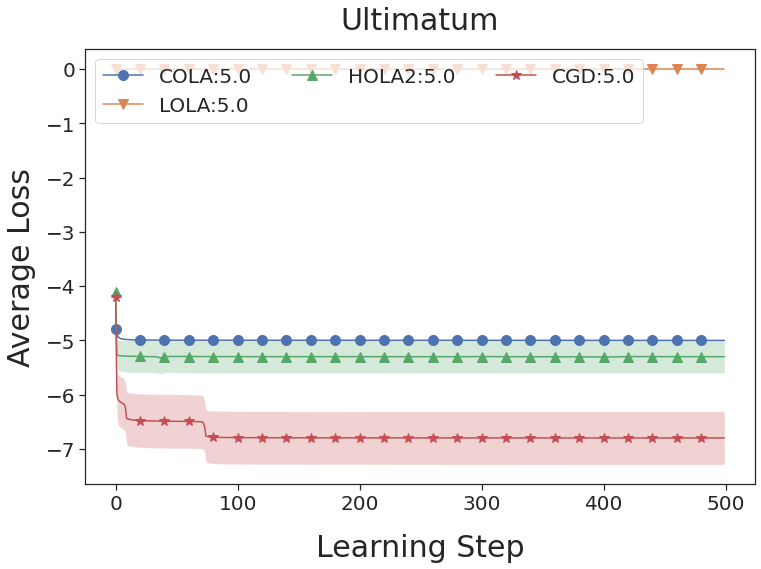

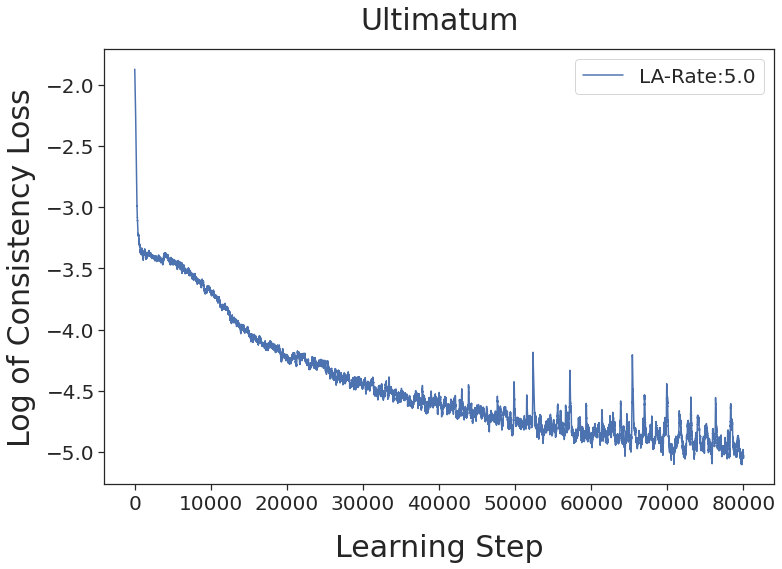

<Figure size 864x576 with 0 Axes>

time: 5min 15s (started: 2022-03-04 02:28:52 +00:00)


In [ ]:
load_from_file = False
if game == 'Ultimatum':
  dims, Ls = ultimatum()
  Ls_batch = Ls
elif game == 'Tandem':
  dims, Ls = tandem()
  Ls_batch = Ls
elif game == 'Matching Pennies':
  dims, Ls = matching_pennies()
  dims_batch, Ls_batch = matching_pennies_batch(batch_size=hyper_params['batch_size'])
elif game == 'Chicken Game':
  dims, Ls = chicken_game()
  dims_batch, Ls_batch = chicken_game_batch(batch_size=hyper_params['batch_size'])
elif game == 'IPD':
  dims, Ls = ipd(hyper_params['gamma'])
  dims, Ls_batch = ipd_batched(hyper_params['gamma'])
elif game == 'Hamiltonian':
  dims, Ls = hamiltonian_game()
  Ls_batch = Ls
elif game == 'Balduzzi':
  dims, Ls = balduzzi()
  Ls_batch = Ls

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (12, 8),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

th_list = []
total_losses_out = np.zeros((int(hyper_params['num_innerloop_long']),))
for m, algorithm in enumerate(['COLA_long', 'LOLA', 'HOLA2', 'CGD']):# 'lola', 'cgd', 'nl' ,'sos', 'HOLA3', 'HOLA4'
  losses_out = np.zeros((hyper_params['num_runs'], hyper_params['num_epochs']))
  losses_out_2 = np.zeros((hyper_params['num_runs'], hyper_params['num_epochs']))
  th = init_th(dims, hyper_params['std'])

  if algorithm == 'COLA_long':
    h_net_long = Net()
    k_net_long = Net()
    if load_from_file:
      h_net_long = load_checkpoint('h_net_long.pth', h_net_long)
      k_net_long = load_checkpoint('k_net_long.pth', k_net_long)
    else:
      adam_h_long = optim.Adam(h_net_long.parameters(), lr=hyper_params['lr'])
      adam_k_long = optim.Adam(k_net_long.parameters(), lr=hyper_params['lr'])
      scheduler_h_long = optim.lr_scheduler.StepLR(adam_h_long, 750, gamma=hyper_params['lr_scheduler']) #0.8 750
      scheduler_k_long = optim.lr_scheduler.StepLR(adam_k_long, 750, gamma=hyper_params['lr_scheduler'])
      total_losses_out, total_losses_norm, total_losses_dot = nn_batched_pretrain_colav2(Ls_batch, interval=interval, hyper_params=hyper_params, net1=h_net_long, 
                                net2=k_net_long, adam1=adam_h_long, adam2=adam_k_long, scheduler1=scheduler_h_long, scheduler2=scheduler_k_long,
                                num_innerloop=hyper_params['num_innerloop_long'],
                                beta=hyper_params['beta'], total_losses_out=total_losses_out)

  for i in range(hyper_params['num_runs']):
      for k in range(hyper_params['num_epochs']):
        if  algorithm == 'COLA_long':
          th, losses, _ = cola_v2(th, Ls, hyper_params['alpha'], beta=hyper_params['beta'], k_net=k_net_long, h_net=h_net_long)
          if game == 'IPD':
            losses_out[i, k] = (1-hyper_params['gamma'])*losses[0].data.numpy()
            losses_out_2[i, k] = (1-hyper_params['gamma'])*losses[1].data.numpy()
          losses_out[i, k] = losses[0].data.numpy()
          losses_out_2[i, k] = losses[1].data.numpy()
        elif algorithm == 'HOLA1':
          th, losses, _ = update_th(th, Ls, hyper_params['alpha'], algo='higher_order_lola', order=1, beta=hyper_params['beta'])
          losses_out[i, k] = losses[0].data.numpy()
          losses_out_2[i, k] = losses[1].data.numpy()          
        elif algorithm == 'HOLA2':
          th, losses, _ = update_th(th, Ls, hyper_params['alpha'], algo='higher_order_lola', order=2, beta=hyper_params['beta'])
          losses_out[i, k] = losses[0].data.numpy()
          losses_out_2[i, k] = losses[1].data.numpy()
        elif algorithm == 'HOLA3':
          th, losses, _ = update_th(th, Ls, hyper_params['alpha'], algo='higher_order_lola', order=3, beta=hyper_params['beta'])
          losses_out[i, k] = losses[0].data.numpy()
          losses_out_2[i, k] = losses[1].data.numpy()
        elif algorithm == 'HOLA4':
          th, losses, _ = update_th(th, Ls, hyper_params['alpha'], algo='higher_order_lola', order=4, beta=hyper_params['beta'])
          losses_out[i, k] = losses[0].data.numpy()
          losses_out_2[i, k] = losses[1].data.numpy()
        elif algorithm == 'HOLA5':
          th, losses, _ = update_th(th, Ls, hyper_params['alpha'], algo='higher_order_lola', order=2, beta=hyper_params['beta'])
          losses_out[i, k] = losses[0].data.numpy()
          losses_out_2[i, k] = losses[1].data.numpy()
        elif algorithm == 'CGD':
          th, losses, _ = update_th(th, Ls, hyper_params['alpha'], algo='cgd', beta=hyper_params['beta'])
          losses_out[i, k] = losses[0].data.numpy()
          losses_out_2[i, k] = losses[1].data.numpy()
        elif algorithm == 'SOS':
          th, losses, _ = update_th(th, Ls, hyper_params['alpha'], algo='sos', beta=hyper_params['beta'])
          losses_out[i, k] = losses[0].data.numpy()
          losses_out_2[i, k] = losses[1].data.numpy()               
      if algorithm == 'COLA_long':
        th_list.append(th)
      print(th, 'th '+algorithm)
      th = init_th(dims, hyper_params['std'])

  mean = np.mean((losses_out), axis=0)
  dev = stats.mstats.sem((losses_out), axis=0)

  plt.plot(np.arange(hyper_params['num_epochs']), mean, markers[m]+'-', markersize=10.0, markevery=20)
  plt.fill_between(np.arange(hyper_params['num_epochs']), mean - dev, mean + dev, alpha=0.25)

plt.title(game, fontsize=fontsize, pad=20)
plt.xlabel('Learning Step', fontsize=fontsize, labelpad=20)
plt.xticks(fontsize=20)
plt.ylabel('Average Loss', fontsize=fontsize, labelpad=10)
plt.yticks(fontsize=20)
plt.legend(['COLA:'+str(hyper_params['beta']),
            'LOLA:'+str(hyper_params['beta']),
            'HOLA2:'+str(hyper_params['beta']),
          'CGD:'+str(hyper_params['beta']), 
          # 'SOS:'+str(hyper_params['beta']),
          ], loc='upper left', frameon=True, framealpha=0.75, ncol=3, fontsize=20)
plt.show()
plt.clf()

total_losses = np.log(total_losses_out)

plt.plot(smooth(total_losses, hyper_params['smoothing']), label="LA-Rate:"+str((hyper_params['beta'])))
plt.title(game, fontsize=fontsize, pad=20)
plt.xlabel('Learning Step', fontsize=fontsize, labelpad=20)
plt.ylabel('Log of Consistency Loss', fontsize=fontsize, labelpad=10)
plt.legend(fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
# plt.tight_layout()
plt.show()
plt.clf()


hyper_params['state_dict'] = h_net_long.state_dict()
torch.save(hyper_params, 'h_net_long.pth')
hyper_params['state_dict'] = k_net_long.state_dict()
torch.save(hyper_params, 'k_net_long.pth')
# download checkpoint file
np.save('total_losses.npy', total_losses)

## Calculating the Consistency Loss over an area
Note: This can take up a lot of RAM, especially when evaluated on IPD and high orders of HOLA.

In [ ]:
from torch.nn import CosineSimilarity
cos = CosineSimilarity(dim=0, eps=1e-15)

alpha = hyper_params['alpha']
beta = hyper_params['beta']


interval = hyper_params['interval']

r1 = -interval
r2 = interval

num_samples = 100
for beta in [beta]: # 0.02, 0.03, 0.04, 0.05, 0.06, 0.07
  print('Beta: ', beta)
  for algo in ['cola', 'hola1', 'hola2', 'hola3', 'sos', 'cgd']:
    total_loss_dot = 0
    total_loss_norm = 0
    total_loss = 0
    total_loss_squared_diff = 0
    total_cola_dot = 0
    for m in range(num_samples):
      theta_x = (r1 - r2) * torch.rand(hyper_params['output_dim'], requires_grad=True) + r2
      theta_y = (r1 - r2) * torch.rand(hyper_params['output_dim'], requires_grad=True) + r2
      betas = torch.ones((1, 1))* beta
      th = [theta_x, theta_y]

      if algo == 'cola':
        if hyper_params['input_dim'] == 10:
          inp = torch.cat([theta_x.unsqueeze(0), theta_y.unsqueeze(0)], dim=1)
        else:
          inp = torch.cat([theta_x.unsqueeze(0), theta_y.unsqueeze(0)], dim=1)

        th_prime = [th[0], th[1]]

        x_comp = k_net_long(inp).squeeze(0)
        y_comp = h_net_long(inp).squeeze(0) 
        th_delta_y = [th[0], th[1] + (beta)*y_comp]
        th_delta_x = [th[0] + (beta)*x_comp, th[1]]
        loss_delta_y = Ls(th_delta_y)[0]
        loss_delta_x = Ls(th_delta_x)[1]
        incons_gradX_loss_delta_y = -get_gradient(loss_delta_y, th[0])
        incons_gradY_loss_delta_x = -get_gradient(loss_delta_x, th[1])

        x_comp_cola = x_comp
        y_comp_cola = y_comp
        cola_cons = torch.cat([x_comp_cola, y_comp_cola])

      elif algo == 'hola1':
        _, _, grads_lola = update_th(th=th, Ls=Ls, alpha=alpha, algo='higher_order_lola', order=1, beta=beta)
        x_comp = -grads_lola[0]
        y_comp = -grads_lola[1]
        th_delta_y = [th[0], th[1] + beta*y_comp]
        th_delta_x = [th[0] + beta*x_comp, th[1]]
        loss_delta_y = Ls(th_delta_y)[0]
        loss_delta_x = Ls(th_delta_x)[1]
        incons_gradX_loss_delta_y = -get_gradient(loss_delta_y, th[0])
        incons_gradY_loss_delta_x = -get_gradient(loss_delta_x, th[1])

      elif algo == 'hola2':
        _, _, grads_hola2 = update_th(th=th, Ls=Ls, alpha=alpha, algo='higher_order_lola', order=2, beta=beta)
        x_comp = -grads_hola2[0]
        y_comp = -grads_hola2[1]
        th_delta_y = [th[0], th[1] + beta*y_comp]
        th_delta_x = [th[0] + beta*x_comp, th[1]]
        loss_delta_y = Ls(th_delta_y)[0]
        loss_delta_x = Ls(th_delta_x)[1]
        incons_gradX_loss_delta_y = -get_gradient(loss_delta_y, th[0])
        incons_gradY_loss_delta_x = -get_gradient(loss_delta_x, th[1])

      elif algo == 'hola3':
        _, _, grads_hola3 = update_th(th=th, Ls=Ls, alpha=alpha, algo='higher_order_lola', order=4, beta=beta)
        x_comp = -grads_hola3[0]
        y_comp = -grads_hola3[1]
        th_delta_y = [th[0], th[1] + beta*y_comp]
        th_delta_x = [th[0] + beta*x_comp, th[1]]
        loss_delta_y = Ls(th_delta_y)[0]
        loss_delta_x = Ls(th_delta_x)[1]
        incons_gradX_loss_delta_y = -get_gradient(loss_delta_y, th[0])
        incons_gradY_loss_delta_x = -get_gradient(loss_delta_x, th[1])

      else:
        _, _, grads_sos = update_th(th=th, Ls=Ls, alpha=alpha, algo=algo, beta=beta)
        x_comp = -grads_sos[0]
        y_comp = -grads_sos[1]
        th_delta_y = [th[0], th[1] + beta*y_comp]
        th_delta_x = [th[0] + beta*x_comp, th[1]]
        loss_delta_y = Ls(th_delta_y)[0]
        loss_delta_x = Ls(th_delta_x)[1]
        incons_gradX_loss_delta_y = -get_gradient(loss_delta_y, th[0])
        incons_gradY_loss_delta_x = -get_gradient(loss_delta_x, th[1])

      incons_grad = torch.cat([incons_gradX_loss_delta_y, incons_gradY_loss_delta_x])
      cons_grad = torch.cat([x_comp, y_comp])

      incons_grad_norm = F.normalize(incons_grad, dim=0)
      cons_grad_norm = F.normalize(cons_grad, dim=0)

      total_loss_dot += cos(cons_grad, incons_grad)
      total_loss_norm += ((cons_grad_norm - incons_grad_norm)**2).sum()
      total_loss += torch.norm(cons_grad - incons_grad)
      total_loss_squared_diff += ((cons_grad - incons_grad)**2).sum()


    total_loss_dot /= num_samples
    total_loss_norm /= num_samples
    total_loss /= num_samples
    total_loss_squared_diff /= num_samples


    print('Total Loss DOT '+algo+': ', total_loss_dot.item())
    print('Total Loss (normalized updates) '+algo+': ', total_loss_norm.item())
    print('Total Loss '+algo+': ', total_loss.item())
    print('Total Loss Squared Diff '+algo+': ', total_loss_squared_diff.item())

    print('\n')

Beta:  5.0
Total Loss DOT cola:  0.9199844598770142
Total Loss (normalized updates) cola:  0.1600307822227478
Total Loss cola:  0.04207858070731163
Total Loss Squared Diff cola:  0.006944224704056978


Total Loss DOT hola1:  0.8228126764297485
Total Loss (normalized updates) hola1:  0.35437464714050293
Total Loss hola1:  0.40924566984176636
Total Loss Squared Diff hola1:  1.167171597480774


Total Loss DOT hola2:  0.9590317010879517
Total Loss (normalized updates) hola2:  0.0819370299577713
Total Loss hola2:  0.08757105469703674
Total Loss Squared Diff hola2:  0.11475656181573868


Total Loss DOT hola3:  0.8846787214279175
Total Loss (normalized updates) hola3:  0.23064281046390533
Total Loss hola3:  0.35996896028518677
Total Loss Squared Diff hola3:  4.1860671043396


Total Loss DOT sos:  0.9021897315979004
Total Loss (normalized updates) sos:  0.19562038779258728
Total Loss sos:  0.19346940517425537
Total Loss Squared Diff sos:  0.3749452233314514


Total Loss DOT cgd:  0.94142740964

## Calculating simlarity between COLA and HOLA
Note: This can take up a lot of RAM, especially when evaluated on IPD and high orders of HOLA.

In [ ]:
from torch.nn import CosineSimilarity
cos = CosineSimilarity(dim=0, eps=1e-15)
alpha = hyper_params['alpha']
beta = hyper_params['beta']

interval = hyper_params['interval']


r1 = -interval
r2 = interval

num_samples = 1000
for algo in ['hola1', 'hola4', 'hola6', 'sos']: #
  total_cola_dot = 0
  for m in range(num_samples):
    theta_x = (r1 - r2) * torch.rand(hyper_params['output_dim'], requires_grad=True) + r2
    theta_y = (r1 - r2) * torch.rand(hyper_params['output_dim'], requires_grad=True) + r2
    betas = torch.ones((1, 1))* beta
    th = [theta_x, theta_y]
    # COLA #
    if hyper_params['input_dim'] == 10:
      inp = torch.cat([theta_x.unsqueeze(0), theta_y.unsqueeze(0)], dim=1)
    else:
      inp = torch.cat([theta_x.unsqueeze(0), theta_y.unsqueeze(0)], dim=1)

    x_comp = k_net_long(inp).squeeze(0) 
    y_comp = h_net_long(inp).squeeze(0) 

    x_comp_cola = x_comp
    y_comp_cola = y_comp
    cola_cons = torch.cat([x_comp_cola, y_comp_cola])

    if algo == 'hola1':
      _, _, grads_lola = update_th(th=th, Ls=Ls, alpha=alpha, algo='higher_order_lola', order=1, beta=beta)
      x_comp = -grads_lola[0]
      y_comp = -grads_lola[1]

    elif algo == 'hola4':
      _, _, grads_hola2 = update_th(th=th, Ls=Ls, alpha=alpha, algo='higher_order_lola', order=2, beta=beta)
      x_comp = -grads_hola2[0]
      y_comp = -grads_hola2[1]

    elif algo == 'hola6':
      _, _, grads_hola3 = update_th(th=th, Ls=Ls, alpha=alpha, algo='higher_order_lola', order=4, beta=beta)
      x_comp = -grads_hola3[0]
      y_comp = -grads_hola3[1]

    else:
      _, _, grads_sos = update_th(th=th, Ls=Ls, alpha=alpha, algo=algo, beta=beta)
      x_comp = -grads_sos[0]
      y_comp = -grads_sos[1]

    cons_grad = torch.cat([x_comp, y_comp])

    total_cola_dot += cos(cola_cons, cons_grad)

  total_cola_dot /= num_samples

  print('Dot Product COLA '+algo+': ', total_cola_dot.item())
  print('\n')

Dot Product COLA hola1:  0.7338825464248657


Dot Product COLA hola4:  0.7564603090286255


Dot Product COLA hola6:  0.7030609250068665


Dot Product COLA sos:  0.7323294878005981


time: 15.4 s (started: 2022-03-04 02:34:12 +00:00)


## Gradient fields for LOLA and COLA

Does not work for IPD since IPD has 5 parameters per agent.

/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
No handles with labels found to put in legend.


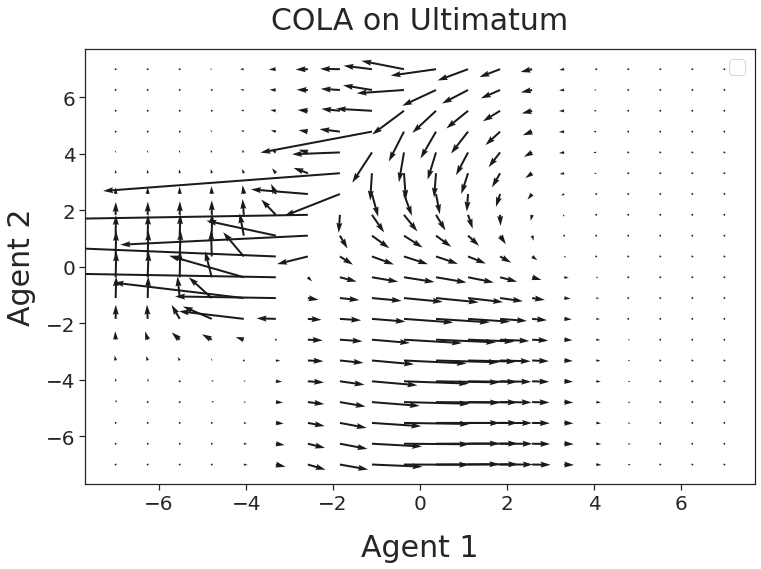

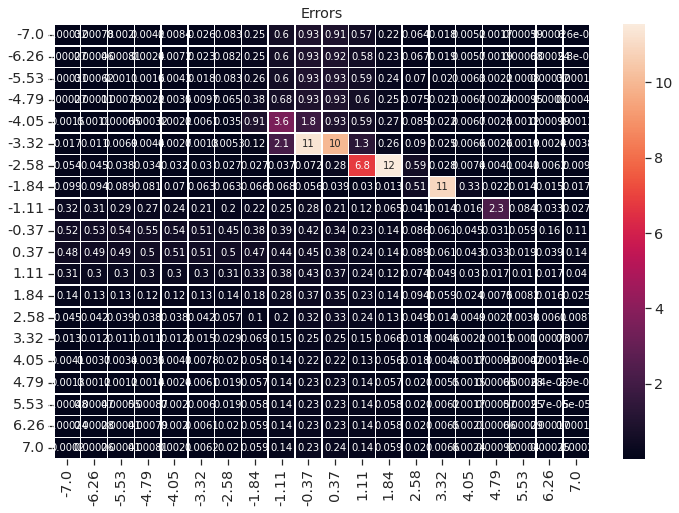

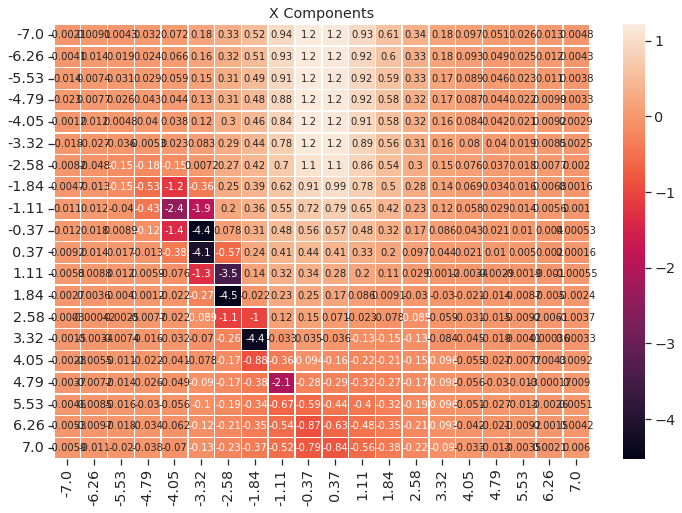

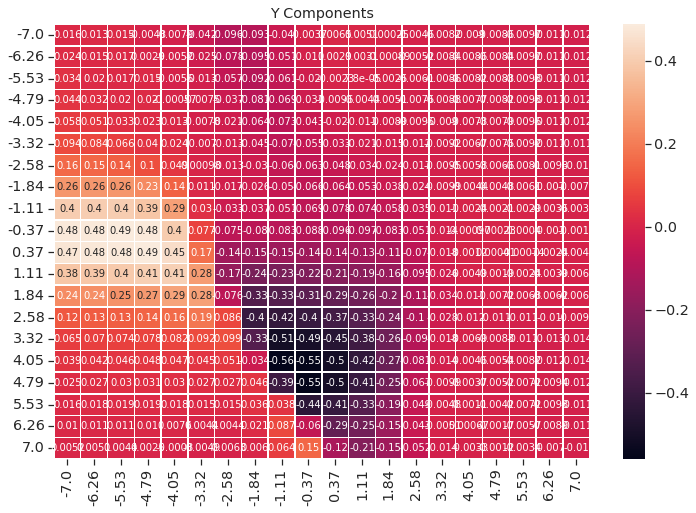

<Figure size 864x576 with 0 Axes>

time: 5 s (started: 2022-03-04 02:34:28 +00:00)


In [ ]:
grain=20
interval = hyper_params['interval']
dims_batch, Ls_batch = matching_pennies_batch(batch_size=grain**2)
x_comps, y_comps, errors, th = find_local_min_colav2(Ls=Ls_batch, grain=grain, interval=interval)


x_comps_cola_pt = x_comps
y_comps_cola_pt = y_comps
x_comps_cola = x_comps.detach().numpy()
y_comps_cola = y_comps.detach().numpy()
errors_cola = errors.detach().numpy()




x,y = np.meshgrid(np.linspace(-interval, interval, grain),np.linspace(-interval, interval, grain))

# plt.figure(figsize=(15, 8))
plt.quiver(x, y, x_comps_cola, y_comps_cola)
plt.xlabel('Agent 1', fontsize=fontsize, labelpad=20)
plt.ylabel('Agent 2', fontsize=fontsize, labelpad=10)
plt.legend(fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title(f"COLA on {game}", fontsize=fontsize, pad=20)
plt.show()
plt.clf()

ticks = np.linspace(-interval, interval, grain).round(2)

ax = sns.heatmap(errors_cola, annot=True, linewidth=0.5, xticklabels=ticks, yticklabels=ticks)
plt.title("Errors")
plt.show()
plt.clf()

ax = sns.heatmap(x_comps_cola, annot=True, linewidth=0.5, xticklabels=ticks, yticklabels=ticks)
plt.title("X Components")
plt.show()
plt.clf()

ax = sns.heatmap(y_comps_cola, annot=True, linewidth=0.5, xticklabels=ticks, yticklabels=ticks)
plt.title("Y Components")
plt.show()
plt.clf()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.float` is a deprecat

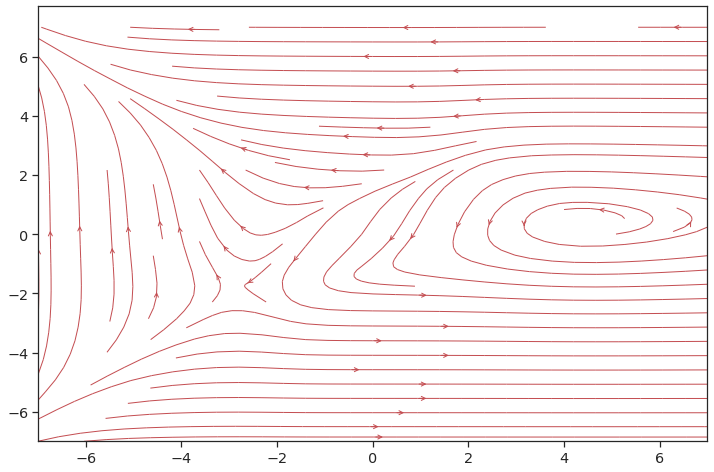

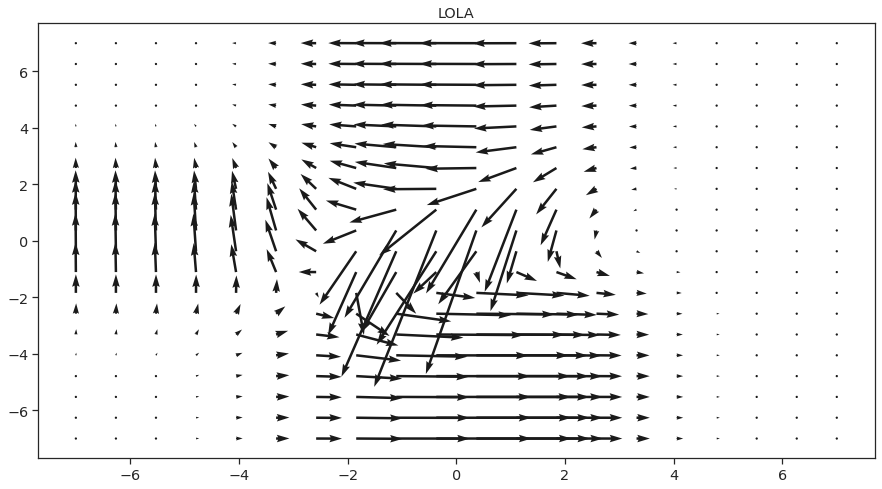

<Figure size 864x576 with 0 Axes>

time: 1.83 s (started: 2022-03-04 02:34:33 +00:00)


In [ ]:
from torch.nn import functional as F
alpha = hyper_params['alpha']
beta= hyper_params['beta']
algorithm = 'higher_order_lola'

x_comps = torch.zeros([grain, grain], dtype=np.float)
y_comps = torch.zeros([grain, grain], dtype=np.float)
errors = torch.zeros([grain, grain], dtype=np.float)
lspace = torch.linspace(-interval, interval, grain, requires_grad=True)

for i in range(grain):
  for j in range(grain):
    theta_0 = lspace[i].unsqueeze(-1)
    theta_1 = lspace[j].unsqueeze(-1)
    th = [theta_0, theta_1]
    _, _, grads = update_th(th=th, Ls=Ls, alpha=alpha, algo=algorithm, order=1, beta=beta)
    x_comp = -grads[0]
    y_comp = -grads[1]
    i_index, j_index = int(i), int(j)
    x_comps[j_index, i_index] = x_comp
    y_comps[j_index, i_index] = y_comp

    th_delta_y = [th[0], th[1] + alpha*y_comp]
    th_delta_x = [th[0] + alpha*x_comp, th[1]]
    loss_delta_y = Ls(th_delta_y)[0]
    loss_delta_x = Ls(th_delta_x)[1]
    incons_gradX_loss_delta_y = -get_gradient(loss_delta_y, th[0])
    incons_gradY_loss_delta_x = -get_gradient(loss_delta_x, th[1])
    incons_grad = torch.cat([incons_gradX_loss_delta_y, incons_gradY_loss_delta_x])
    cons_grad = torch.cat([x_comp, y_comp])
    total_loss = torch.norm(F.normalize(cons_grad, dim=0) - F.normalize(incons_grad, dim=0)) 
    errors[j_index, i_index] = total_loss


x,y = np.meshgrid(np.linspace(-interval, interval, grain), np.linspace(-interval, interval, grain))

x_comps_lola_pt = x_comps
y_comps_lola_pt = y_comps
x_comps_lola = x_comps.detach().numpy()
y_comps_lola = y_comps.detach().numpy()
errors_lola = errors.detach().numpy()
plt.streamplot(x, y, x_comps_lola, y_comps_lola, color='r', linewidth=1,
              density=1, arrowstyle='->', arrowsize=1)
plt.figure(figsize=(15, 8))
plt.quiver(x, y, x_comps_lola, y_comps_lola) #, errors_lola)
plt.title('LOLA')
plt.show()
plt.clf()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: `np.float` is a deprecated alia

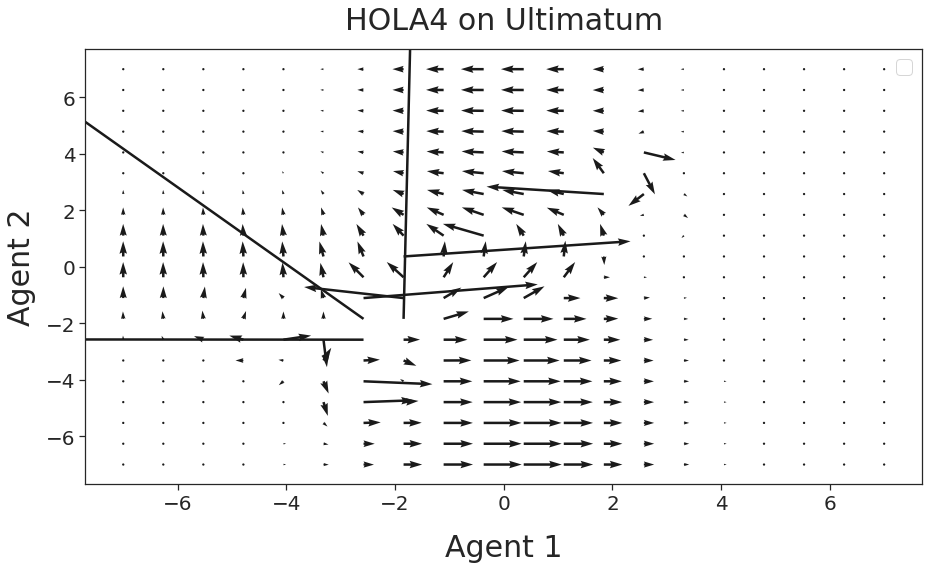

torch.Size([400, 1])


<Figure size 864x576 with 0 Axes>

time: 7.95 s (started: 2022-03-04 02:34:34 +00:00)


In [ ]:
alpha = 10
beta = 10
algorithm = 'higher_order_lola'

x_comps = torch.zeros([grain, grain], dtype=np.float)
y_comps = torch.zeros([grain, grain], dtype=np.float)
errors = torch.zeros([grain, grain], dtype=np.float)
lspace = torch.linspace(-interval, interval, grain, requires_grad=True)

for i in range(grain):
  for j in range(grain):
    theta_0 = lspace[i].unsqueeze(-1)
    theta_1 = lspace[j].unsqueeze(-1)
    th = [theta_0, theta_1]
    _, _, grads = update_th(th=th, Ls=Ls, alpha=alpha, beta=beta, algo=algorithm, order=4)
    x_comp = -grads[0]
    y_comp = -grads[1]
    i_index, j_index = int(i), int(j)
    x_comps[j_index, i_index] = x_comp
    y_comps[j_index, i_index] = y_comp

    th_delta_y = [th[0], th[1] + beta*y_comp]
    th_delta_x = [th[0] + beta*x_comp, th[1]]
    loss_delta_y = Ls(th_delta_y)[0]
    loss_delta_x = Ls(th_delta_x)[1]
    incons_gradX_loss_delta_y = -get_gradient(loss_delta_y, th[0])
    incons_gradY_loss_delta_x = -get_gradient(loss_delta_x, th[1])
    incons_grad = torch.cat([incons_gradX_loss_delta_y, incons_gradY_loss_delta_x])
    cons_grad = torch.cat([x_comp, y_comp])
    total_loss = torch.norm(F.normalize(cons_grad, dim=0) - F.normalize(incons_grad, dim=0)) 
    errors[j_index, i_index] = total_loss


x,y = np.meshgrid(np.linspace(-interval, interval, grain),np.linspace(-interval, interval, grain))

x_comps_hola6_pt = x_comps
y_comps_hola6_pt = y_comps
x_comps_hola6 = x_comps.detach().numpy()
y_comps_hola6 = y_comps.detach().numpy()
errors_hola6 = errors.detach().numpy()

plt.figure(figsize=(15, 8))
plt.quiver(x, y, x_comps_hola6, y_comps_hola6)#, errors_hola6)
plt.xlabel('Agent 1', fontsize=fontsize, labelpad=20)
plt.ylabel('Agent 2', fontsize=fontsize, labelpad=10)
plt.legend(fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title(f"HOLA4 on {game}", fontsize=fontsize, pad=20)
plt.show()
plt.clf()

x_comps_hola6_flat = x_comps_hola6_pt.reshape(-1, 1)
y_comps_hola6_flat = y_comps_hola6_pt.reshape(-1, 1)
print(x_comps_hola6_flat.size())

